In [1]:
%autosave 0

In [2]:
import os
startup_file = "/Users/octavia/Dropbox/fire/src_v1/startup.py"

In [3]:
run "/Users/octavia/Dropbox/fire/src_v1/startup.py"

## The $G_l$-ignition feedback

 Assume that return time linearly decreases as G_l increases

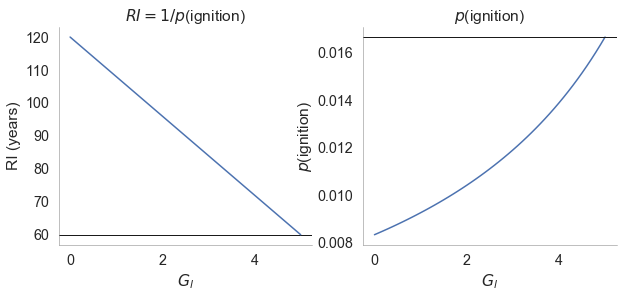

In [4]:

p = RCSR()
fig, axes = plt.subplots(1,2, figsize = (10,4))
ax = axes[0]

G_l = np.arange(0, p.k_l+.1 , 0.1)
RI_l = p.RI + p.chi*p.RI - p.chi*p.RI/p.k_l*G_l
ax.axhline(p.RI, c = "k", lw = 1)
ax.plot(G_l, RI_l)
ax.set_xlabel("$G_l$")
ax.set_ylabel("RI (years)")
ax.set_title("$RI = 1/p$(ignition) ")

ax = axes[1]
ax.plot(G_l, 1/RI_l)
ax.axhline(1/p.RI, c = "k", lw = 1)
ax.set_xlabel("$G_l$")
ax.set_ylabel("$p$(ignition)")
ax.set_title("$p$(ignition)")
fig.savefig(fig_dir + '/G_l_feedback.png', format='png', dpi=300, bbox_inches = "tight")
# The RI prescribed in the code is the minimum RI. The maximum ignition probabiliy is 1/RI.

## Simulation 

In [5]:
# Simulation batch
sim_dir = project_dir + "/sims_G_l"
file_dir = sim_dir + "/all_sims"
if os.path.isdir(file_dir)  == False:
    os.mkdir(file_dir)
    
sys.path.append(sim_dir)
if "params" in sys.modules:
    del sys.modules["params"]
from params import all_params


In [6]:
all_sims = read_all_sims(file_dir)

In [7]:
res = compute_all_summary(all_sims, sim_dir)
res = pd.read_pickle(sim_dir + "/summary.pkl")
res.severity = np.round(res.severity,2)
res.p = 1/res.RI 

In [8]:
print_all_params(all_params)

batch vars:
  beta [0.5]
  S [0.4, 0.2]
  alpha [0.02, 0.06]
  ignition_type ['G_l', 'random']
sim vars:
  RI [10 20 30 40 50 60 70 80 90]
  severity [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


### Select a simulation `p` from the $G_l$ feedback simulations;  subset `res` to match that case, grouping by no feedback ( `random`) and  $G_l$ feedback.

In [9]:
res_random = res[res.ignition_type == "random"]
res_feedback = res[res.ignition_type == "G_l"]

case = res[(res.ignition_type == "G_l") & 
           (res_feedback.alpha == 0.02) & 
           (res_feedback.severity == 0.8) & 
           (res_feedback.RI == 20) & 
           (res_feedback.S == 0.2) ].iloc[0]
print (case.name)

random_subset = res_random[(res_random.alpha==case.alpha) &
                           (res_random.S==case.S) &
                           (res_random.beta == case.beta)]
feedback_subset = res_feedback[(res_feedback.alpha==case.alpha) & 
                               (res_feedback.S==case.S) & 
                               (res_feedback.beta == case.beta)]


key = case.name
p = all_sims.loc[key].p


S-0.2,alpha-0.02,beta-0.5,ignition_type-G_l,RI-20,severity-0.8


### Select from `random_subset` the no-feedback simulation that most closely matches `p`; save this 

In [10]:
err_l = np.abs(random_subset.G_l_mean - case.G_l_mean)
err_u = np.abs(random_subset.G_u_mean - case.G_u_mean)
random_subset["err_l"] = err_l
random_subset["err_u"] = err_u
random_subset["err"] = np.sqrt(err_u**2 + err_l**2)

tol = 1
match= random_subset[(err_l  < tol) & (err_u < tol)]
if len(match) == 0:
    print ("increase stop tol")
    
match_key = match[match['err'] == match['err'].min()].index[0]
p_match = all_sims.loc[match_key]["p"]
match_case = random_subset.loc[match_key]
match_case[["err", "err_u", "err_l"]]

err       0.177944
err_u     0.171839
err_l    0.0462121
Name: S-0.2,alpha-0.02,beta-0.5,ignition_type-random,RI-10,severity-0.5, dtype: object

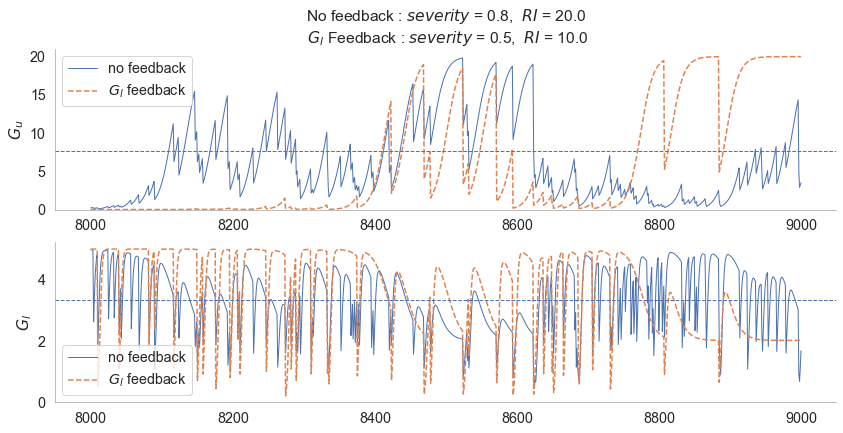

In [11]:
title = "No feedback : " + print_dict(case[["severity","RI"]]) + "\n $G_l$ Feedback : " + \
            print_dict(match_case[["severity","RI"]]) 
canopy_compare(p, p_match, nfire = 100, title = title)
# what is the "average" trajectory?

In [27]:

compare = pd.DataFrame({"no_feedback" : match_case, "G_l_feedback" : case })
compare.loc["p"] = 1/compare.loc["RI"]
compare.where(compare.G_l_feedback != compare.no_feedback).dropna().round(2)

,no_feedback,G_l_feedback
G_l_mean,3.47788,3.52409
G_u_mean,6.24655,6.07471
RI,10,20
RI_c,9.21609,22.25
RI_std_c,8.90809,21.8406
ignition_type,random,G_l
p,0.1,0.05
severity,0.5,0.8
severity_c,0.4971,0.800452
severity_std_c,0.101966,0.0957213


In [28]:
def format_axes(x_var, y_var, ax):
    
    label_dict = {
            "RI" : "min $RI$",
            "p" : "max $p$",
            "RI_c" : "actual $RI$",
            "G_u_mean" : r"$\hat G_u$",
             "G_l_mean" : r"$\hat G_l$"
    
            }
    
    ax.set_ylabel(label_dict[y_var])
    ax.set_xlabel(label_dict[x_var])
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    return ax

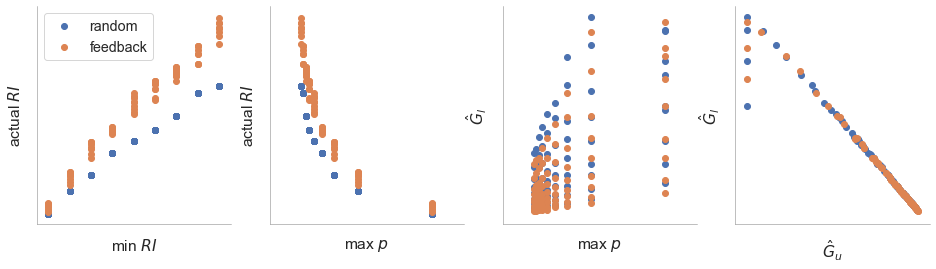

In [29]:

fig, axes = plt.subplots(1,4 , figsize = (16,4))
axes= axes.ravel()
alpha = 1
plot_vars = [["RI", "RI_c"],
            ["p", "RI_c"],
            ["p", "G_l_mean"],
             ["G_u_mean", "G_l_mean"]
            ]

for i, ax in enumerate(axes[:len(plot_vars)]):
    x_var, y_var = plot_vars[i]
    ax.scatter(random_subset[x_var], random_subset[y_var],
               alpha = alpha, label = "random")
    ax.scatter(feedback_subset[x_var], feedback_subset[y_var],
               alpha = alpha, label = "feedback")

    format_axes(x_var, y_var, ax)

axes[0].legend()


In [30]:
x_var = "RI"
y_var = "severity"
feedback_subset = feedback_subset.sort_values(by = [x_var, y_var])
random_subset = random_subset.sort_values(by = [x_var, y_var])

In [31]:
def plot_grid_feedback(feedback_subset, random_subset, x_var, y_var):
    """
    Gridded plot of G_u and G_l predicted mean and errors, 
    over a 2D grid of parameter values (`x_var` and `y_var`)
    
    """


    fig, axes = plt.subplots(2,2, figsize = (12, 8))
    axes = axes.ravel()
    maps = reformat_to_grid(feedback_subset,x_var, y_var)
    y = expand(maps[y_var].copy())
    x = expand(maps[x_var].copy())
    
    ax = axes[0]
    z = expand_z(np.array(maps["G_u_mean"]))
    ax.set_xticks([], []);    
    ax, zplot = colormap(x,y, z, ax= ax)
    ax.set_ylabel("Severity")
    ax.set_title(r"$\bar G_u$ with feedback ")
    
    ax = axes[1]
    z = expand_z(np.array(maps["G_l_mean"]))
    ax, zplot = colormap(x,y, z, ax= ax)
    ax.set_yticks([], []);
    ax.set_xticks([], []);        
    ax.set_title(r"$\bar G_l$ with feedback")

    maps = reformat_to_grid(random_subset,x_var, y_var)
    y = expand(maps[y_var].copy())
    x = expand(maps[x_var].copy())    
    
    ax = axes[2]
    z = expand_z(np.array(maps["G_u_mean"]))
    ax.set_xticks([], []);    
    ax, zplot = colormap(x,y, z, ax= ax)
    ax.set_ylabel("Severity")
    ax.set_title(r"$\bar G_u$ no feedback ")
    
    ax = axes[3]
    z = expand_z(np.array(maps["G_l_mean"]))
    ax, zplot = colormap(x,y, z, ax= ax)
    ax.set_yticks([], []);
    ax.set_xticks([], []);        
    ax.set_title(r"$\bar G_l$ no feedback")
    
    
    return axes

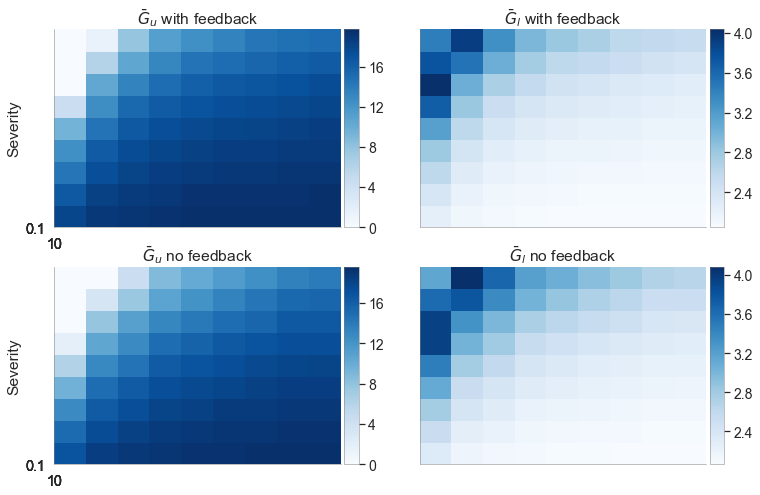

In [32]:
 plot_grid_feedback(feedback_subset, random_subset, x_var, y_var);

Text(0.5, 1.0, 'Histogram of $G_{u,max}$ values')

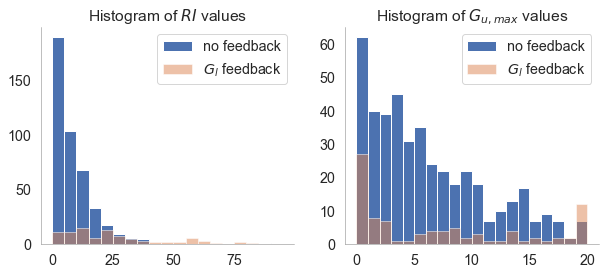

In [33]:

fig, axes = plt.subplots(1,2, figsize = (10,4))
ax = axes[0]
bins = np.arange(0, 100, 5)
bins = ax.hist(p_match.record.time_past_fire, bins, label = "no feedback");
ax.hist(p.record.time_past_fire, bins[1], alpha= 0.5, label = "$G_l$ feedback");
ax.legend()
ax.set_title("Histogram of $RI$ values")

ax = axes[1]
bins = ax.hist(p_match.record.G_u_max, 20,  label = "no feedback");
ax.hist(p.record.G_u_max, bins[1], alpha= 0.5, label = "$G_l$ feedback");
ax.legend()
ax.set_title("Histogram of $G_{u,max}$ values")


In [34]:
p.record["u_removed"] = p.record.G_u_max*p.record.u_severity
p.record["l_removed"] = p.record.G_l_max*p.record.l_severity

p_match.record["u_removed"] = p_match.record.G_u_max*p.record.u_severity
p_match.record["l_removed"] = p_match.record.G_l_max*p.record.l_severity


Text(0.5, 1.0, 'Histogram of \n lower canopy biomass removed')

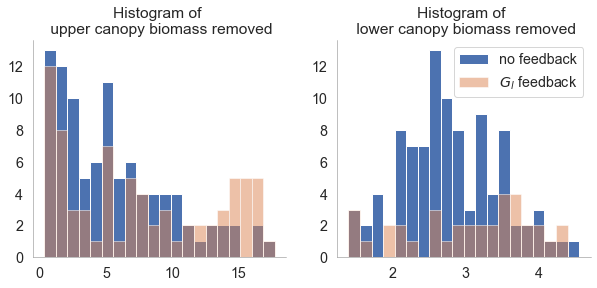

In [35]:
## Biomass removed
fig, axes = plt.subplots(1,2, figsize = (10,4))
ax = axes[0]
# bins = np.arange(0, 100, 5)
bins = ax.hist(p_match.record.u_removed, 20, label = "no feedback");
ax.hist(p.record.u_removed, bins[1], alpha= 0.5, label = "$G_l$ feedback");
# ax.legend() 
ax.set_title("Histogram of \n upper canopy biomass removed")

ax = axes[1]
bins = ax.hist(p_match.record.l_removed, 20,  label = "no feedback");
ax.hist(p.record.l_removed, bins[1], alpha= 0.5, label = "$G_l$ feedback");
ax.legend()
ax.set_title("Histogram of \n lower canopy biomass removed")

# Illustrates feedback without matching

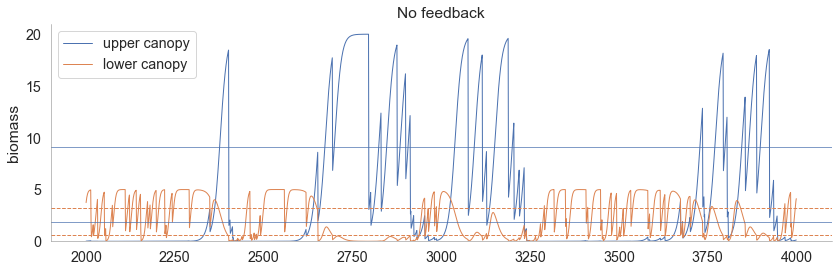

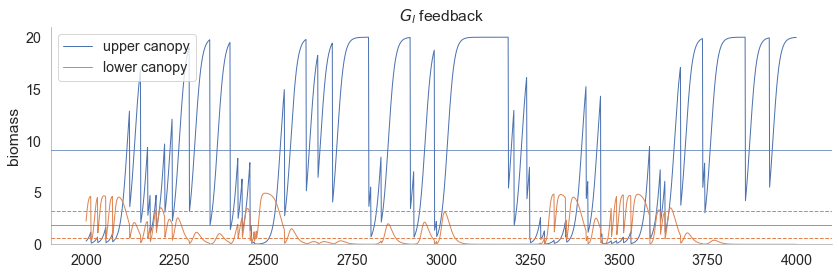

In [21]:

p = RCSR()
# params = default
update = {
          "r_l" : 0.45,
          "r_u" : 0.15,           
          "alpha" : 0.02,
          "beta" : 0.5,
          "RI" : 20,
          "severity" : 0.80,
          "severity_type" : "random",
          "ignition_type" : "G_l",          
          "sigma_phi" : 0.01,
          "seed" : 0,
          "chi" : 1,
          "S" : 0.5
         }


p = RCSR(update)
p.run()


update_fix = update.copy()
update_fix["ignition_type"] = "random"
p1 = RCSR(update_fix)
p1.run()

canopy_plot(p1, nfire = 100, title = "No feedback")
canopy_plot(p, nfire = 100, title = "$G_l$ feedback")

Text(0.5, 1.0, 'Histogram of $G_{u,max}$ values')

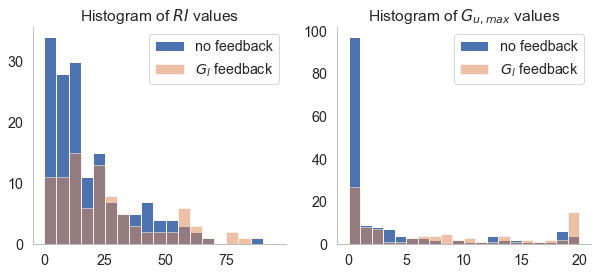

In [22]:
fig, axes = plt.subplots(1,2, figsize = (10,4))
ax = axes[0]
bins = np.arange(0, 100, 5)
bins = ax.hist(p1.record.time_past_fire, bins, label = "no feedback");
ax.hist(p.record.time_past_fire, bins[1], alpha= 0.5, label = "$G_l$ feedback");
ax.legend()
ax.set_title("Histogram of $RI$ values")

ax = axes[1]
bins = ax.hist(p1.record.G_u_max, 20,  label = "no feedback");
ax.hist(p.record.G_u_max, bins[1], alpha= 0.5, label = "$G_l$ feedback");
ax.legend()
ax.set_title("Histogram of $G_{u,max}$ values")


## Trajectory plot?
Code not working 

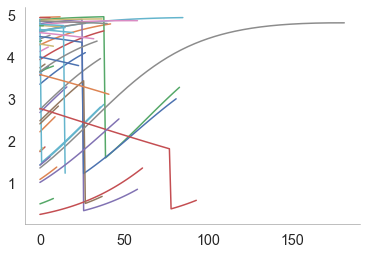

In [36]:

for i, d in enumerate(p.record.year[:-1]):
    start = round(d)
    end = int(round(d + p.record.time_past_fire[i+1] - 2/p.dt_p))
    plt.plot(p.G_l_list[start:end])